In [1]:
import numpy # linear algebra
import pandas # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3 # Database
import hashlib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
# Connect to db
# Tables: ascent, grade, method, user
db = sqlite3.connect('input/database.sqlite')
cursor = db.cursor()

In [3]:
# city, country messy, so not used for now
sql = """SELECT id, sex, height, weight, started, competitions, birth FROM user"""
users = pandas.read_sql(sql, db)
users['birth'] = pandas.to_datetime(users['birth'], errors='coerce') # Invalid set to NaN
users.head(10)

,id,sex,height,weight,started,competitions,birth
0,1,0,177,73,1996,,1976-03-10
1,2,0,0,0,2000,,NaT
2,3,0,180,78,1995,,1973-09-09
3,4,1,165,58,2001,,1984-07-26
4,5,0,0,0,1991,,1969-05-07
5,6,0,185,73,1992,last,1970-12-02
6,10,0,167,63,1992,,1965-06-22
7,11,0,175,73,1998,1:a,1980-01-09
8,12,0,0,0,2000,,NaT
9,13,0,0,0,2000,,NaT


In [4]:
sql = f"""SELECT user_id, grade_id FROM ascent"""
grades_per_user = pandas.read_sql(sql, db).groupby('user_id').agg(['count', 'mean'])
grades_per_user.columns = ['n_ascents', 'mean_grade']
grades_per_user.describe()

,n_ascents,mean_grade
count,36034.000000,36034.000000
mean,114.111034,44.701745
std,216.875290,8.727258
min,1.000000,1.000000
25%,9.000000,38.714286
50%,35.000000,44.857143
75%,125.000000,50.943031
max,5541.000000,81.000000


In [5]:
users = pandas.merge(users, grades_per_user, left_on='id', right_index=True)
users.shape
# Inner merge, hence dropping ~half the users (need both user info and grade info)

(36031, 9)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f544128c470>,
      dtype=object)

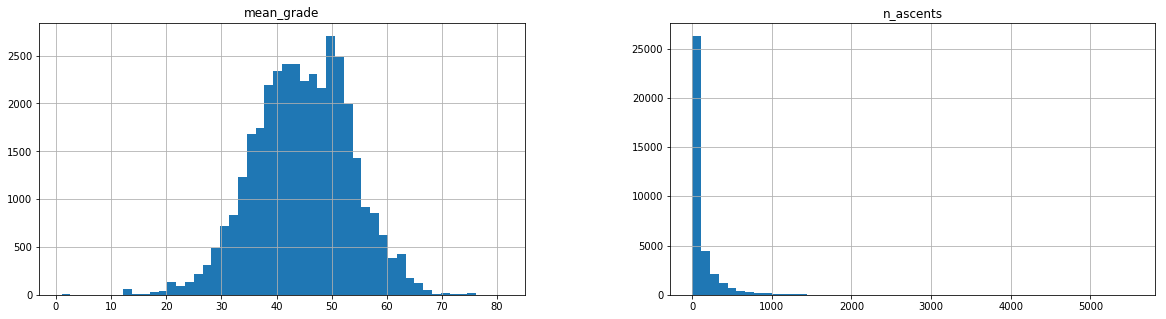

In [6]:
users[grades_per_user.columns].hist(bins=50, figsize=(20,5))
# Neither are very gaussian...
# #ascents is OK, but mean grade is strange...

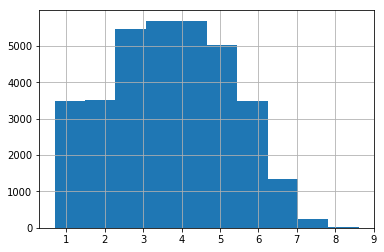

In [7]:
numpy.log(users[users['n_ascents'] > 1]['n_ascents']).hist() # Looks a bit lognormal, with a peak at one-time users

In [8]:
# Correlations?
corr_matrix = users.corr()
corr_matrix['mean_grade'].sort_values(ascending=False)
# Those who are active (climb and compete) much are better -> Stratified sampling for training?
# The smaller and lighter the better - note though: spurious values! Need to get rid of them!

mean_grade    1.000000
n_ascents     0.125275
sex          -0.012835
started      -0.032901
height       -0.043327
weight       -0.047808
id           -0.118128
Name: mean_grade, dtype: float64

# Training and test set

In [9]:
def test_set_check(identifier, test_ratio, hash_function):
    return hash_function(numpy.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash_function=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash_function))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
train_set, test_set = split_train_test_by_id(users, 0.2, 'id')

# Cleaning

['id' 'first_name' 'last_name' 'city' 'country' 'sex' 'height' 'weight'
 'started' 'competitions' 'occupation' 'sponsor1' 'sponsor2' 'sponsor3'
 'best_area' 'worst_area' 'guide_area' 'interests' 'birth' 'presentation'
 'deactivated' 'anonymous']
       
Cleaning steps
* Choose only relevant columns
* Transform competitions to filled/unfilled
* Transform birth to age
* Get rid of obvious input issues: strange ages, heights and weights
* Maybe don't consider very infrequent users? Stratified sampling by #ascents?

In [11]:
# Use only training set
users = train_set.copy()
users['age'] = users['birth']
users.drop('birth', axis=1, inplace=True)

grade_labels = users.mean_grade

column_ix_name_dict = dict(zip(users.columns, range(users.shape[1])))
column_ix_name_dict

{'id': 0,
 'sex': 1,
 'height': 2,
 'weight': 3,
 'started': 4,
 'competitions': 5,
 'n_ascents': 6,
 'mean_grade': 7,
 'age': 8}

In [72]:
users.info()
# A lot of dates are missing and many people have not competed (missing/'')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28775 entries, 0 to 62589
Data columns (total 9 columns):
id              28775 non-null int64
sex             28775 non-null int64
height          28775 non-null int64
weight          28775 non-null int64
started         28775 non-null int64
competitions    25603 non-null object
n_ascents       28775 non-null int64
mean_grade      28775 non-null float64
age             17161 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 2.2+ MB


In [73]:
class CompetitionPresentTransformator(BaseEstimator, TransformerMixin):
    def __init__(self, column_ix_name_dict):
        self.col_ix = column_ix_name_dict['competitions']
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        comp_present = numpy.full(X.shape[0],1)
        comp_present[X[:,self.col_ix] == None] = 0
        comp_present[X[:,self.col_ix] == ''] = 0
        X[:,self.col_ix] = comp_present
        return X

In [74]:
def to_years(pandas_timedelta):
    return pandas_timedelta.total_seconds() / (60*60*24*365)

to_years_vec = numpy.vectorize(to_years)

age_ix = column_ix_name_dict['age']
class BirthToAgeTransformator(BaseEstimator, TransformerMixin):
    def __init__(self, column_ix_name_dict):
        self.col_ix = column_ix_name_dict['age']
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X[:,self.col_ix] = (pandas.Timestamp.now() - X[:,self.col_ix])
        X[:,self.col_ix] = to_years_vec(X[:,self.col_ix]) # In years, roughly
        return X

In [222]:
problematic_values = {'sex': 255,
                      'started': 0}

class MissingValueSetter(BaseEstimator, TransformerMixin):
    def __init__(self, problematic_values, column_ix_name_dict):
        self.problematic_values = problematic_values
        self.column_ix_name_dict = column_ix_name_dict
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for col_name, value in zip(self.problematic_values.keys(), self.problematic_values.values()):
            if col_name in self.column_ix_name_dict:
                col_ix = self.column_ix_name_dict[col_name]
                X[X[:,col_ix] == value, col_ix] = numpy.nan
        return X

In [223]:
valid_ranges = {'height': (120, 230),
               'weight': (30, 120),
               'started': (1900, 2019),
               'age': (10,100)} # After age transformation

class InvalidRangeSetter(BaseEstimator, TransformerMixin):
    def __init__(self, valid_ranges, column_ix_name_dict):
        self.valid_ranges = valid_ranges
        self.column_ix_name_dict = column_ix_name_dict
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for col_name, col_range in zip(self.valid_ranges.keys(), self.valid_ranges.values()):
            if col_name in self.column_ix_name_dict:
                col_ix = self.column_ix_name_dict[col_name]

                X[X[:,col_ix] == None, col_ix] = col_range[0]-10 # To fix problem with None-s
                X[X[:,col_ix] < col_range[0], col_ix] = None

                X[X[:,col_ix] == None, col_ix] = col_range[1]+10 # To fix problem with None-s
                X[X[:,col_ix] > col_range[1], col_ix] = None
        return X

In [224]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names].values.copy()

In [225]:
class Floater(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for i in range(X.shape[1]):
            X[:,i] = X[:,i].astype(float)
        return X

In [226]:
num_attributes = ['height', 'weight', 'started', 'n_ascents', 'age']
num_column_ix_name_dict = dict(zip(num_attributes, range(len(num_attributes))))

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attributes)),
    ('birth_to_age', BirthToAgeTransformator(num_column_ix_name_dict)),
    ('invalid_value', MissingValueSetter(problematic_values, num_column_ix_name_dict)),
    ('invalid_range', InvalidRangeSetter(valid_ranges, num_column_ix_name_dict)),
    ('floater', Floater()),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

In [237]:
cat_attributes = ['competitions','sex']
cat_column_ix_name_dict = dict(zip(cat_attributes, range(len(cat_attributes))))

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attributes)),
    ('competition_present', CompetitionPresentTransformator(cat_column_ix_name_dict)),
    ('invalid_value', MissingValueSetter(problematic_values, cat_column_ix_name_dict)),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('floater', Floater())
])

In [238]:
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [239]:
users_prepared = full_pipeline.fit_transform(users)

setting 0 in started to None
setting 255 in sex to None


In [240]:
numpy.where(pandas.isnull(users_prepared))

(array([], dtype=int64), array([], dtype=int64))

In [241]:
imputer=SimpleImputer(strategy="most_frequent")
imputer.fit_transform(users_prepared)

array([[0.0930241126351643, 0.5854791941829219, -1.3196081388088288, ...,
        1.293416835080128, 0.0, 0.0],
       [0.0930241126351643, -0.023253482473708453, -0.6807192167402395,
        ..., -0.0629356457041948, 0.0, 0.0],
       [0.5107036363650376, 1.1942118708395524, -1.479330369325976, ...,
        1.68585854477941, 0.0, 0.0],
       ...,
       [0.23225062054512205, 1.1942118708395524, 0.11789193584549704,
        ..., -1.4678597729244645, 0.0, 0.0],
       [0.5107036363650376, 1.1942118708395524, 0.11789193584549704, ...,
        -1.033723818054502, 0.0, 0.0],
       [1.2068361759148263, -0.023253482473708453, 1.8748364715341175,
        ..., -0.7771107833442374, 0.0, 0.0]], dtype=object)

# Let's try some models!

In [256]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [268]:
def evaluate_regressor(regressor_class):
    regressor = regressor_class()
    regressor.fit(users_prepared, grade_labels)
    grade_predictions = regressor.predict(users_prepared)
    
    mse = mean_squared_error(grade_labels, grade_predictions)
    rmse = numpy.sqrt(mse)
    print(f"Training error: {rmse}")
    
    cv_scores = cross_val_score(regressor, users_prepared, grade_labels,
                               scoring="neg_mean_squared_error", cv=10)
    cv_rmse = numpy.mean(numpy.sqrt(-cv_scores))
    print(f"Mean CV error: {cv_rmse}")
    
    plt.plot(grade_labels, grade_predictions, '.')
    plt.plot(grade_labels, grade_labels, 'k-')
    plt.show()

Training error: 8.109756186505104
Mean CV error: 8.099170346149807


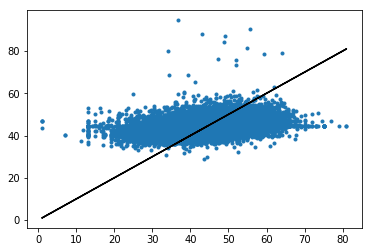

In [269]:
evaluate_regressor(LinearRegression)

Training error: 4.363192224091574
Mean CV error: 10.496047213104138


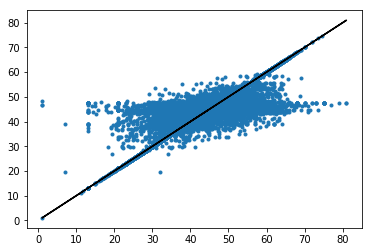

In [270]:
evaluate_regressor(DecisionTreeRegressor)

/home/veronika/anaconda3/envs/handson_ml/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training error: 5.249904911927772
Mean CV error: 8.504724244999016


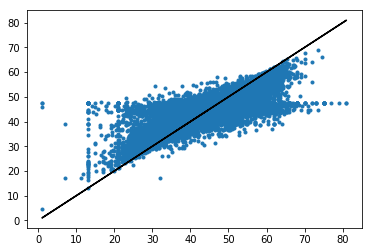

In [271]:
evaluate_regressor(RandomForestRegressor)